# The Real Difference Between Scaling, Normalization and Log Transformations with Sklearn
## Become a pro in preprocessing your numeric features
![](./images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@eye4dtail?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>George Becker</a>
        on 
        <a href='https://www.pexels.com/photo/grayscale-photography-of-three-wise-monkey-figurines-134402/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [4]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(1121218)
warnings.filterwarnings("ignore")

### What does it mean to conform to statistical approaches?

You have probably came across this in courses or articles: 

> The features in the dataset should conform to the statistical assumptions of the models.

What does it mean to conform to statistical assumptions? Many models implemented in Sklearn might perform poorly if the numeric features do not more or less follow a standard Gaussian (normal) distribution. With the exception of tree-based models, the objective function of Sklearn algorithms *assume* the features follow a normal distribution. 

Actually, using the word *assume* would be putting things lightly. For models like K-Nearest-Neighbors, feature transformation is a requirement for the algorithm to perform expectedly:

In [5]:
### HIDE
from sklearn.model_selection import train_test_split

ansur_num = (
    pd.read_csv("data/ansur_male.csv", encoding="latin")
    .select_dtypes(include="number")
    .drop("weightkg", axis=1)
)

X, y = ansur_num.iloc[:, :-1], ansur_num.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.neighbors import KNeighborsRegressor

# Before feature transforming
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
print(
    "Test score of KNN before feature transformation: {}".format(
        knn.score(X_test, y_test)
    )
)

Test score of KNN before feature transformation: 0.8663552265106172


In [7]:
from sklearn.preprocessing import StandardScaler

# Transform
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

# After feature transforming
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
print(
    "Test score of KNN after feature transformation: {}".format(
        knn.score(X_test_scaled, y_test)
    )
)

Test score of KNN after feature transformation: 0.9166671893134017


In practice, you may even face scenarios where feature transformations have even larger effect than 5% increase in performance.

There are many techniques you can apply to make your features more or less follow a normal distribution. They differ based on the underlying distributions of each feature. 

In this article, you will learn about 3 of such techniques: Scaling, normalization and logarithmic tranformers. You will develop a practical understanding of their differences and when to apply them in your own workflow.

### Identifying the Underlying Distribution of Features

Before applying any of the techniques you will be learning, it is important to visually explore each feature. You don't have to create perfect plots, simple histograms and boxplots with default styles will be enough to identify distributions. Take a look at these histograms from the Diamonds dataset of Seaborn:

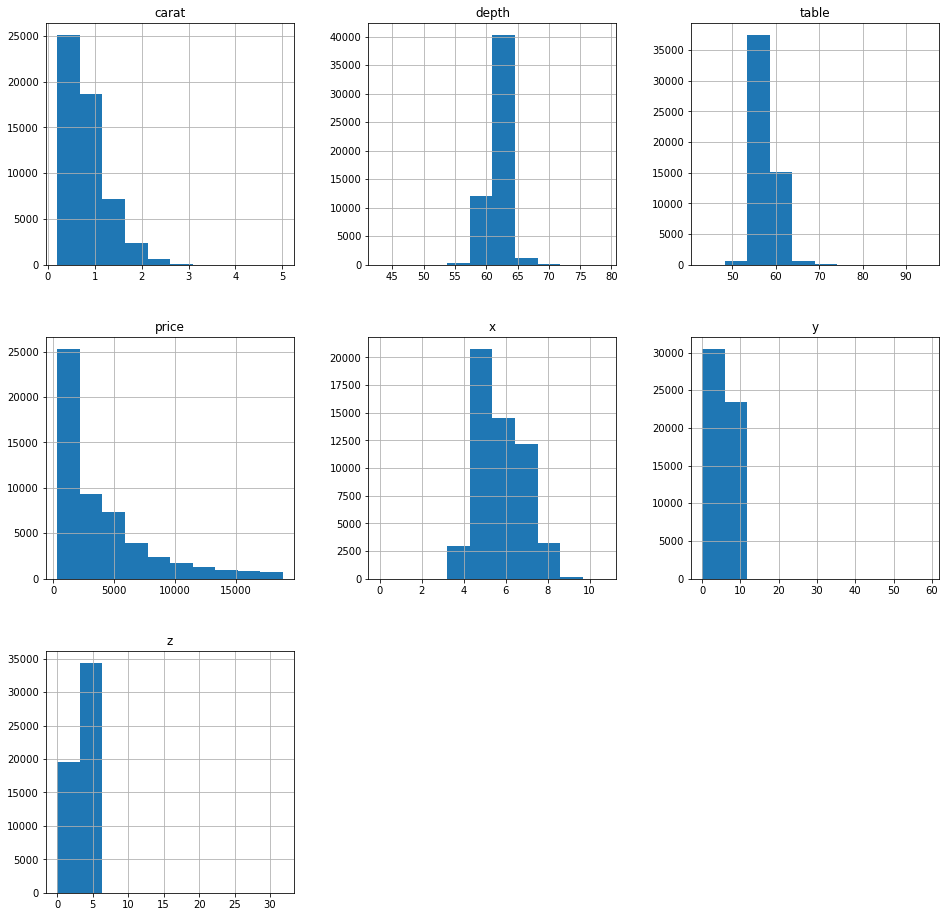

In [11]:
diamonds = sns.load_dataset("diamonds")

diamonds.hist(figsize=(16, 16));

Pay close attention to the shape of the distributions and the ranges on the X axes. From the subplots, we can see that price and carat features follow a skewed distribution. Depth, table and *x* may remotely resemble a normal distribution. 

Apart from the distributions, the range of values is also an important aspect of features. Boxplots are best at showing this using the 5-figure summary:

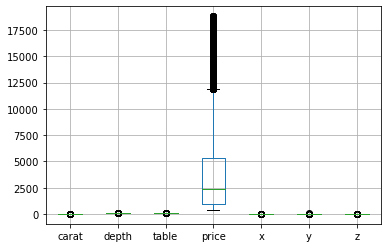

In [14]:
diamonds.boxplot();

The above plot is enough to tell us that the features in the diamonds dataset have very different scales. As diamond prices have a larger scale of values, they squished other plots into a line. Here is the 5-figure summary for further comparison:

In [19]:
diamonds.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.80,0.47,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.75,1.43,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.46,2.23,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.80,3989.44,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.73,1.12,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.73,1.14,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.54,0.71,0.0,2.91,3.53,4.04,31.80


Now that you learned how to identify the shape of the distributions and the difference of each feature's scale, by the end of the article we will have made all features have the same scale and more or less follow a normal distribution like so:

<AxesSubplot:>

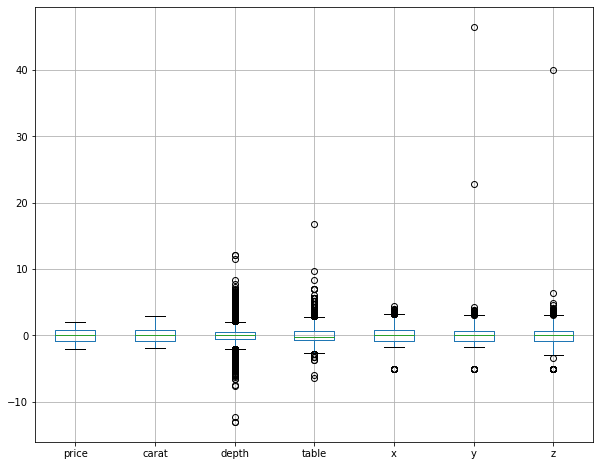

In [129]:
### Hide
diamonds = sns.load_dataset("diamonds")

logs = pd.DataFrame(PowerTransformer().fit_transform(diamonds[to_log]), columns=to_log)
scaled = pd.DataFrame(
    StandardScaler().fit_transform(diamonds[to_scale]), columns=to_scale
)

diamonds = pd.concat([logs, scaled], axis=1)
diamonds.boxplot(figsize=(10, 8));

### Scaling or Standardization with StandardScaler

One of the default methods of solving situations where one feature has a much larger variance than others is using scaling or sometimes called standardization:

In [21]:
diamonds.var().round(2)  ## Variance of each feature

carat           0.22
depth           2.05
table           4.99
price    15915629.42
x               1.26
y               1.30
z               0.50
dtype: float64

According to the [official Sklearn guide](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) on scaling:
> Many elements used in the objective function of a learning algorithm assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.



So, to achieve high performances with many models, scaling is often required. Sklearn implements this in the `StandardScaler()` transformer. It *transforms* numerical features in the dataset so that they have a mean of 0 and a variance of 1. 

SS achieves by using two operations:
1. Centering: subtract the mean from each value in the distribution.
2. Scaling: divide each result by the standard deviation.

The result leaves the original feature following a normal distribution. Here is how we would achieve this manually:

> We are leaving out price and carat feature because they follow a skewed distribution. More on this later.

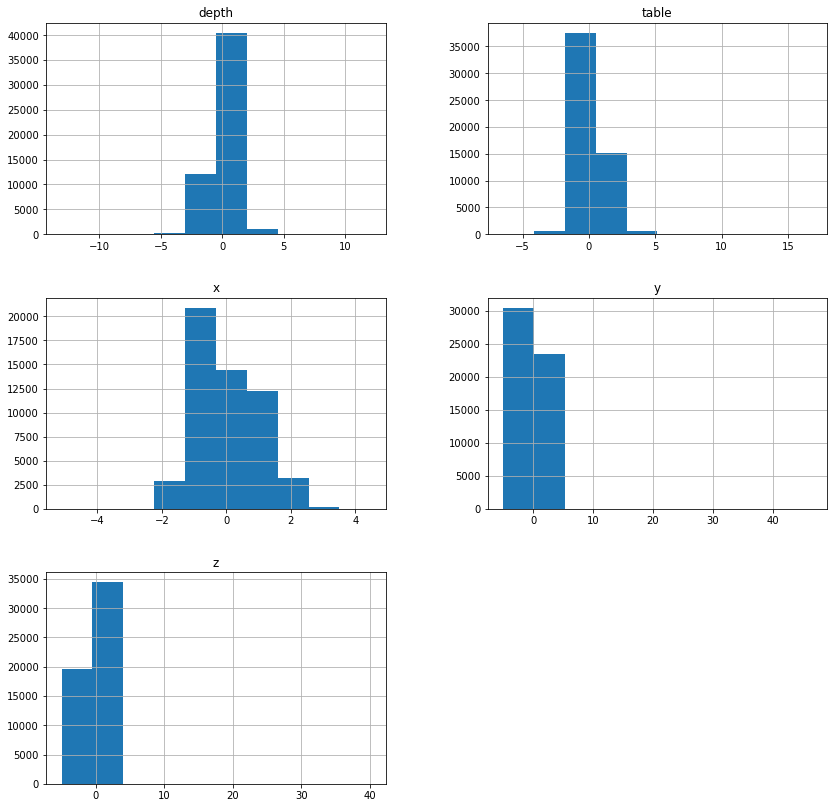

In [24]:
# Center and scale depth, table and x, y, z features
to_scale = ["depth", "table", "x", "y", "z"]
for col in to_scale:
    # Comput mean and std for each col
    mean, std = diamonds[col].mean(), diamonds[col].std()
    diamonds[col] = (diamonds[col] - mean) / std

diamonds[to_scale].hist(figsize=(14, 14));

Let's do the same with the `StandardScaler()`:

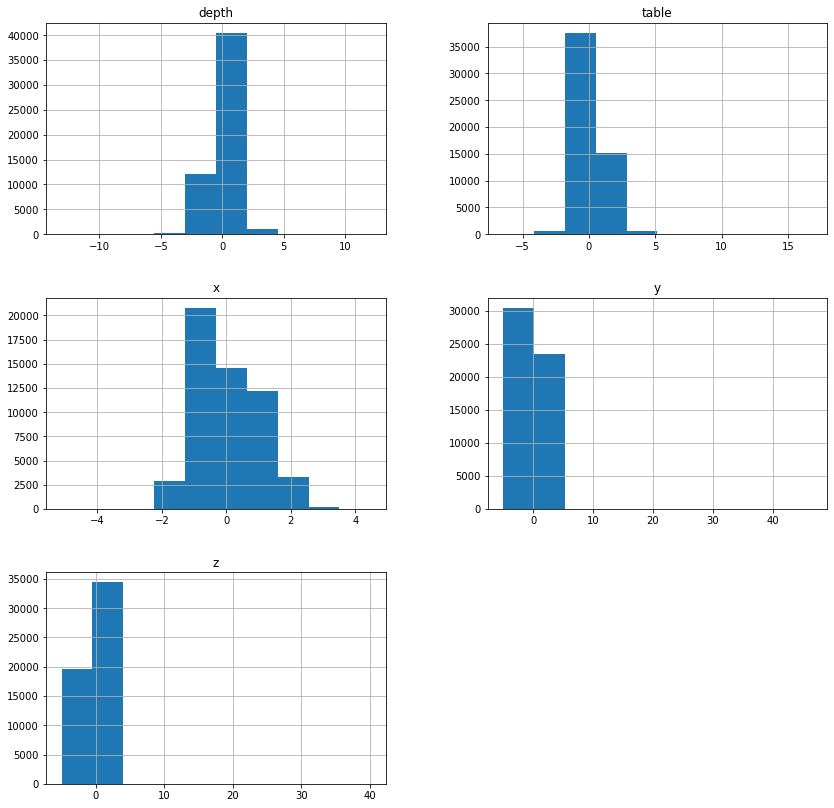

In [28]:
from sklearn.preprocessing import StandardScaler

# Reset the data
diamonds = sns.load_dataset("diamonds")

# Init, fit
ss = StandardScaler()
_ = ss.fit(diamonds[to_scale])

# Transform
diamonds[to_scale] = pd.DataFrame(ss.transform(diamonds[to_scale]), columns=to_scale)

# Plot
diamonds[to_scale].hist(figsize=(14, 14));

The same results. 

Checking the mean and variances:

In [29]:
diamonds[to_scale].var()

depth    1.000019
table    1.000019
x        1.000019
y        1.000019
z        1.000019
dtype: float64

In [31]:
diamonds[to_scale].mean().round(3)

depth   -0.0
table    0.0
x        0.0
y       -0.0
z       -0.0
dtype: float64

Now, let's pay attention to the effectiveness of the scaling. Depth and *x* now genuinely look like a Gaussian distribution. However, the features table, *y* and *z* are still squished into the corner of their plots suggesting the presence of outliers (otherwise, the bulk of the histograms would be in the center). This means the scaling worked better on the depth and *x* features but not on the others. We will make a note of this for the next sections.

### Log Transformation with PowerTransform

When a feature does not follow a linear distribution, it would be unwise to use the mean and the standard deviation to scale it. For example, here is what would have happened if we scaled the skewed distributions of price and carat:

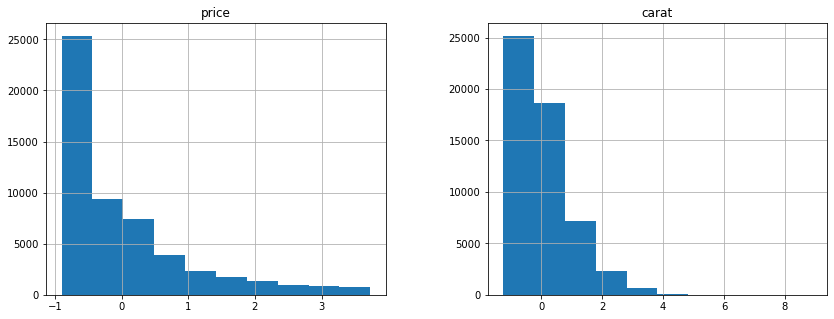

In [35]:
ss = StandardScaler()

diamonds[["price", "carat"]] = ss.fit_transform(diamonds[["price", "carat"]])

diamonds[["price", "carat"]].hist(figsize=(14, 5));

The fact that the features are still skewed confirm that standardization does not work on them. 

To implement non-linear transformations, Sklearn offers a `PowerTransformer` class which helps minimize skewness and map any distribution to a normal one as close as possible:

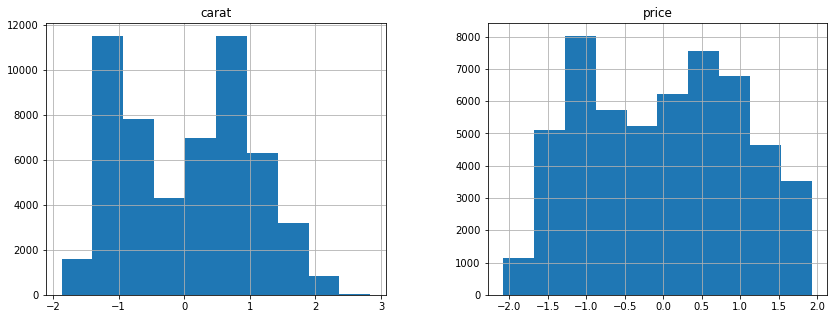

In [37]:
from sklearn.preprocessing import PowerTransformer

# Reset the data
diamonds = sns.load_dataset("diamonds")

# Init
pt = PowerTransformer()

diamonds[["carat", "price"]] = pd.DataFrame(
    pt.fit_transform(diamonds[["carat", "price"]]), columns=["carat", "price"]
)

diamonds[["carat", "price"]].hist(figsize=(14, 5));

In [38]:
diamonds[["carat", "price"]].var()

carat    1.000019
price    1.000019
dtype: float64

The new features looks much better than the old skewed ones. So, whenever faced with a skewed distribution, make use of the `PowerTransformer` class.

### Normalization with MinMaxScaler

An alternative method to scaling is called normalization. Instead of using the variance and the mean, normalizing features involves using the minimum and the maximum values of the distribution. The following equation is used for each value in the distribution:

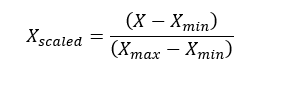

The effect of this transformation is to give the distribution an absolute minimum and a maximum value, usually between 0 and 1. Sklearn provides a similar `MinMaxScaler` transformer to achieve this:

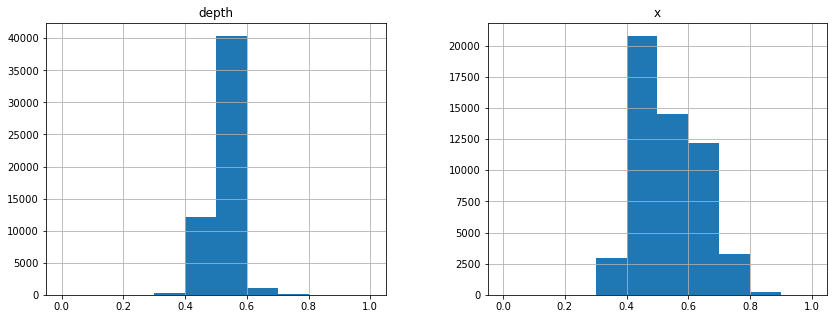

In [42]:
from sklearn.preprocessing import MinMaxScaler

# Reset the data
diamonds = sns.load_dataset("diamonds")
# Select cols to normalize
to_normalize = ["depth", "x"]

mms = MinMaxScaler()

diamonds[to_normalize] = pd.DataFrame(
    mms.fit_transform(diamonds[to_normalize]), columns=to_normalize
)

diamonds[to_normalize].hist(figsize=(14, 5));

Even though it forces features to follow a normal distribution, the features won't have a unit variance and a mean of 0:

In [43]:
diamonds[to_normalize].var()

depth    0.001584
x        0.010909
dtype: float64

In [44]:
diamonds[to_normalize].mean()

depth    0.520817
x        0.533627
dtype: float64

However, there are caveats to using this method. For example, if the maximum value in the training set is smaller than the maximum in test set, the scaling may lead to unexpected results in predictions. The same is true for the minimum value.

Also, MinMaxScaler does not work well with features with outliers. I leave you to think about the reason why (hint: pay attention to the formula of the MMScaler).

Besides, MinMaxScaler does not change the shape of the distribution at all. After normalization, the values lie within some range and the shape of the distribution remains unchanged.

Because of these reasons, StandardScaler is used more often.

### Putting all together

In this section, we will try to predict the diamond cut using a KNNClassifier. We will be using the StandardScaler and PowerTransformer inside a pipeline. If you are not familiar with how Sklearn pipelines and ColumnTransformers work, check out this post:

https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d?source=your_stories_page-------------------------------------

Let's get started. First, we will build the feature/target arrays as well as extract the names of the columns we will be applying the transformers.

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder

# Reset data
diamonds = sns.load_dataset("diamonds")

# Build feature/target arrays
X, y = diamonds.drop("cut", axis=1), diamonds["cut"]

# Set up the colnames
to_scale = ["depth", "table", "x", "y", "z"]
to_log = ["price", "carat"]
categorical = X.select_dtypes(include="category").columns

Next, we will create a ColumnTransformer object which maps the transformers to the relevant columns:

In [99]:
scale_pipe = make_pipeline(StandardScaler())
log_pipe = make_pipeline(PowerTransformer())
categorical_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))

transformer = ColumnTransformer(
    transformers=[
        ("scale", scale_pipe, to_scale),
        ("log_transform", log_pipe, to_log),
        ("oh_encode", categorical_pipe, categorical),
    ]
)

We will plug this transformer into a Pipeline ending with a LogisticRegression:

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([("prep", transformer), ("logistic_reg", LogisticRegression())])

Finally, we divide the data into training and test sets and measure the classifiers performance:

In [119]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Encode the target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# Fit/predict/score
_ = knn_pipe.fit(X_train, y_train)
preds = knn_pipe.predict_proba(X_test)
roc_auc_score(y_test, preds, multi_class="ovr")

0.8358823548104983

We got an ROC AUC score of 0.83. At this point, you can start hyperparameter-tuning to improve on this.

### Data Leakage Considerations For the Above Transformers

Whenever you are doing preprocessing, always watch out for [data leakage](https://www.forcepoint.com/cyber-edu/data-leakage#:~:text=Data%20leakage%20is%20the%20unauthorized,is%20transferred%20electronically%20or%20physically.). Since all the transformers we learned today derive metrics from the underlying distributions of the features, it is easy for them to leak data from the test data.

That's why it is advised to divide the data into train/test sets before doing any preprocessing. Also, never use the `fit_transform()` method on the test set. The transformers should all be fitted to the training data and the subsequent transformations should only use `transform` method:

```python
ss = StandardScaler()
ss.fit(X_train)

X_train = ss.transform(X_train)  ## fit_transform can be used on the train set
X_test = ss.transform(X_test)  ## ONLY .transform method should be used
```

However, when you are using these transformers in pipelines, you don't have to worry about this. Sklearn takes care of data leakage under the hood when fitting and transforming features.

### Summary

In this article, you learned how to feature engineer your numeric features so that they conform to the statistical assumptions of many models. Specifically, we learned how to:
- Scale data using `StandardScaler`, a transformer used when we want a feature to follow a normal distribution with mean 0 and unit variance. Used most often with distributions without many outliers or other generally-shaped distributions.
- Log transform data using `PowerTransformer`, a transformer used when we want a heavily skewed feature to be transformed into a normal distribution as much as possible.
- Normalize data using `MinMaxScaler`, a transformer used when we want the feature values to lie within a certain min and max values. Doesn't work well with many outliers and prone to unexpected behaviors if values go out of the given range in the test set. A less popular alternative to scaling.

### Further Reading
- [Sklearn Preprocessing Official Guide](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
- [How to Use Normal Distribution Like You Know What You Are Doing](https://towardsdatascience.com/how-to-use-normal-distribution-like-you-know-what-you-are-doing-1cf4c55241e3?source=your_stories_page-------------------------------------)
- [How to think Probabilistically with Discrete Distributions](https://towardsdatascience.com/how-to-think-probabilistically-with-discrete-distributions-ea28e2bcafdc?source=your_stories_page-------------------------------------)
- [Logarithmic Scale in Data Science](https://towardsdev.com/logarithmic-scale-how-to-plot-and-actually-understand-it-c38f00212206?source=your_stories_page-------------------------------------)

### You might also be interested...
- [Automatic Hyperparameter Tuning with Sklearn GridSearchCV and RandomizedSearchCV](https://towardsdatascience.com/automatic-hyperparameter-tuning-with-sklearn-gridsearchcv-and-randomizedsearchcv-e94f53a518ee?source=your_stories_page-------------------------------------)
- [11 Times Faster Hyperparameter Tuning with HalvingGridSearch](https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155?source=your_stories_page-------------------------------------)
- [Intro to Object-Oriented Programming For Data Scientists](https://towardsdev.com/intro-to-object-oriented-programming-for-data-scientists-9308e6b726a2?source=your_stories_page-------------------------------------)